## Семинар 7: "Методы оптимизации"

ФИО: Ира Букреева

In [1]:
import numpy as np
#from sklearn.datasets import fetch_mldata
#from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt
import torch
from torchvision import transforms, utils
from torch import nn
from torchvision.datasets import MNIST
from torch.autograd import Variable
from torch.utils.data import DataLoader
from IPython.display import clear_output
import seaborn as sns
%matplotlib inline

На этом семинаре мы попробуем сравнить различные методы оптимизации: GD, Momentum, NAG, Adagrad, Adadelta, Adam.

### Часть 1: Реализация методов

Полезная функция: plt.contour
Для всех экспериментов подберите параметры так, чтобы метод сошелся к ближайшему локальному минимуму. Все методы следует запускать из одной и той же точки.

<i> 1.1 Реализуйте методы GD, Momentum, NAG, Adagrad, Adadelta, Adam.</i>

In [17]:
class Optimizer:
  def __init__(self, parameters):
    self.parameters = parameters

  def zero_grad(self):
    for param in self.parameters:
      try:
        param.grad.zero_()
      except:
        pass
  
  def step(self, F):
    loss = F()
    loss.backward()

class SGD(Optimizer):
  def __init__(self, parameters, lr=0.1):
    #self.parameters = parameters 
    self.parameters = [param for param in parameters] 
    self.lr = lr
  
  #@torch.no_grad()
  def step(self, F=None):
    if F is not None:
      super().step(F)

    with torch.no_grad():
      for param in self.parameters:      
        param -= self.lr * param.grad
        #param.__idiff__(self.lr * param.grad)
        #param = param - self.lr * param.grad
        #param.set_(param - self.lr * param.grad)

class Momentum(Optimizer):
  def __init__(self, parameters, lr=0.1, gamma=0.9):
    self.parameters = parameters    
    self.params_step = [torch.zeros_like(param) for param in self.parameters]

    self.lr = lr
    self.gamma = gamma
  
  def step(self, F=None):
    if F is not None:
      super().step(F)

    with torch.no_grad():
      for param, step in zip(self.parameters, self.params_step):
        step.set_(self.gamma * step + self.lr * param.grad)
        param -= step

class NAG(Optimizer):
  def __init__(self, parameters, lr=0.1, gamma=0.9):
    self.parameters = parameters    
    self.params_step = [torch.zeros_like(param) for param in self.parameters]

    self.lr = lr
    self.gamma = gamma
  
  def step(self, F):
    with torch.no_grad():
      for param, step in zip(self.parameters, self.params_step):
        param -= self.gamma * step

    super().step(F)

    with torch.no_grad():
      for param, step in zip(self.parameters, self.params_step):
        param += self.gamma * step
        
        step.set_(self.gamma * step + self.lr * param.grad)
        param -= step

In [18]:
class Adadelta(Optimizer):
  def __init__(self, parameters, gamma=0.9):
    #self.parameters = parameters
    self.parameters = [param for param in parameters] 
    self.params_gs = [torch.zeros_like(param) for param in self.parameters]

    self.first_call = True    

    self.lr = 1.0
    self.gamma = gamma
    self.eps = 0.0000001
    
  def step(self, F=None):
    if F is not None:
      super().step(F)
    
    sum_step = 0
    num_params = 0
    with torch.no_grad():
      for param, gs in zip(self.parameters, self.params_gs):
        if self.first_call:
          gs.set_(param.grad**2)
        else:
          gs.set_(self.gamma * gs + (1.0 - self.gamma) * param.grad**2)

        step = self.lr / (gs + self.eps).sqrt() * param.grad

        sum_step += step.sum()
        num_params += step.numel()

        param -= step

      self.lr = self.gamma * self.lr + (1.0 - self.gamma) * sum_step / num_params
      #print("new lr:", self.lr)
      self.first_call = False

In [19]:
class Adagrad(Optimizer):
  def __init__(self, parameters):
    #self.parameters = parameters 
    self.parameters = [param for param in parameters]
    self.params_G = [torch.zeros_like(param) for param in self.parameters]
    self.first_call = True 

    self.lr = 1.0
    self.eps = 0.00001
  
  #@torch.no_grad()
  def step(self, F=None):
    if F is not None:
      super().step(F)

    with torch.no_grad():
      for param, G in zip(self.parameters, self.params_G):
        if self.first_call:
          G.set_(param.grad**2)
        else:
          G.set_(G + param.grad**2)

        step = self.lr / (G + self.eps).sqrt() * param.grad

        param.set_(param - step)

      self.first_call = False

In [20]:
class Adam(Optimizer):
  def __init__(self, parameters):
    #self.parameters = parameters
    self.parameters = [param for param in parameters]
    self.params_mt = [torch.zeros_like(param) for param in self.parameters]
    self.params_ut = [torch.zeros_like(param) for param in self.parameters]

    self.lr = 0.01

    self.beta1 = 0.9
    self.beta2 = 0.999
    self.eps = 0.00001
  
  #@torch.no_grad()
  def step(self, F=None):
    if F is not None:
      super().step(F)
    with torch.no_grad():
      for param, mt, ut in zip(self.parameters, self.params_mt, self.params_ut):
        
        mt.set_(self.beta1 * mt + (1.0 - self.beta1) * param.grad)
        ut.set_(self.beta2 * ut + (1.0 - self.beta2) * param.grad**2)
        
        mt_unbias = mt / (1 - self.beta1)
        ut_unbias = ut / (1 - self.beta2)

        #step = self.lr / (ut_unbias.sqrt() + self.eps) * mt_unbias
        param.set_(param - (self.lr / (ut_unbias.sqrt() + self.eps) * mt_unbias))

<i> 1.2 Сравните эти методы на функции $J(x, y) = x^2+y^2$</i>

In [6]:
def f(x):
  #return x[0].sin() + x[1].cos() + (x.sum())**2
  return (x**2).sum(axis=-1)

optimizers = [(SGD, "red"), (Momentum, "green"), (NAG, "blue"), (Adadelta, "black"), (Adagrad, "gray"), (Adam, "purple")]
all_ways = []

for optimizer, _ in optimizers:
  x = nn.Parameter(torch.tensor([0.5, 1.0]))
  optimizer = optimizer([x])

  points = []
  for i in range(300):  
      optimizer.zero_grad()
      optimizer.step(lambda x=x: f(x))

      points.append(x.detach().numpy().copy())

  print(optimizer, f(x))

  points = np.array(points)
  all_ways.append(points)

<__main__.SGD object at 0x7fcec29d9c18> tensor(0., grad_fn=<SumBackward1>)
<__main__.Momentum object at 0x7fcec29d9c18> tensor(2.3662e-14, grad_fn=<SumBackward1>)
<__main__.NAG object at 0x7fcec29d9c18> tensor(1.9898e-43, grad_fn=<SumBackward1>)
<__main__.Adadelta object at 0x7fcec29d9c18> tensor(1.3874e-41, grad_fn=<SumBackward1>)
<__main__.Adagrad object at 0x7fcec29d9c18> tensor(0., grad_fn=<SumBackward1>)
<__main__.Adam object at 0x7fcec29d9c18> tensor(1.2834e-09, grad_fn=<SumBackward1>)


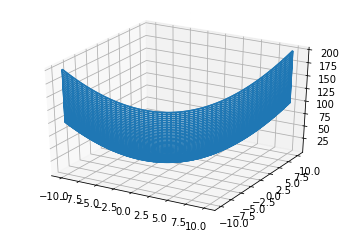

In [7]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
import numpy

def cartesian_product(*arrays):
    la = len(arrays)
    dtype = numpy.result_type(*arrays)
    arr = numpy.empty([len(a) for a in arrays] + [la], dtype=dtype)
    for i, a in enumerate(numpy.ix_(*arrays)):
        arr[...,i] = a
    return arr.reshape(-1, la)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

size = 10
n = 100

X = np.linspace(-size, size, n)
Y = np.linspace(-size, size, n)

Z = f(cartesian_product(X, Y)).reshape(n, n)

#print(Z)

#ax.plot_wireframe(X, Y, Z, rstride=10, cstride=10)
ax.plot_wireframe(X, Y, Z)

plt.show()

(-0.55, 0.55, -0.7939227074384689, 1.0749487727880478)

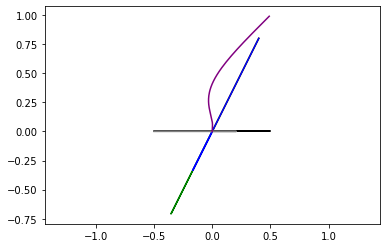

In [8]:
for points, (_, color) in zip(all_ways, optimizers):
  plt.plot(points[:, 0], points[:, 1], c=color)

plt.axis('equal')
# [(SGD, "red"), (Momentum, "green"), (NAG, "blue"), (Adadelta, "black"), (Adagrad, "gray"), (Adam, "purple")]

<i>1.3 Сравните эти методы на функции $J(x, y) = x^2sin(x)+y^2sin(y)$</i>

In [9]:
def f(x):
  return ((x**2) * x.sin()).sum(axis=-1)

optimizers = [(SGD, "red"), (Momentum, "green"), (NAG, "blue"), (Adadelta, "black"), (Adagrad, "gray"), (Adam, "purple")]
all_ways = []

for optimizer, _ in optimizers:
  x = nn.Parameter(torch.tensor([0.5, 1.0]))
  optimizer = optimizer([x])

  points = []
  for i in range(1000):  
      optimizer.zero_grad()
      optimizer.step(lambda x=x: f(x))

      points.append(x.detach().numpy().copy())
      
  print(optimizer, f(x))

  points = np.array(points)
  all_ways.append(points)

<__main__.SGD object at 0x7fcec29d9c18> tensor(7.1974e-08, grad_fn=<SumBackward1>)
<__main__.Momentum object at 0x7fcec29d9c18> tensor(-7.8906, grad_fn=<SumBackward1>)
<__main__.NAG object at 0x7fcec29d9c18> tensor(-7.8906, grad_fn=<SumBackward1>)
<__main__.Adadelta object at 0x7fcec29d9c18> tensor(-3.9453, grad_fn=<SumBackward1>)
<__main__.Adagrad object at 0x7fcec29d9c18> tensor(-3.9453, grad_fn=<SumBackward1>)
<__main__.Adam object at 0x7fcec29d9c18> tensor(8.8457e-06, grad_fn=<SumBackward1>)


(-4.225875872373581,
 0.7145656526088715,
 -3.241157999634743,
 1.1914837867021562)

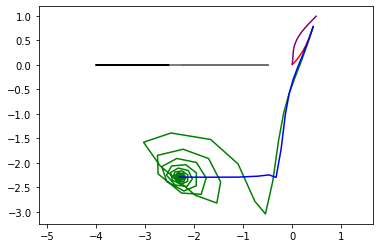

In [10]:
for points, (_, color) in zip(all_ways, optimizers):
  plt.plot(points[:, 0], points[:, 1], c=color)

plt.axis('equal')
#[(SGD, "red"), (Momentum, "green"), (NAG, "blue"), (Adadelta, "black"), (Adagrad, "gray"), (Adam, "purple")]

<i>1.3 Сравните эти методы на функции $J(x,y)=x^2sin(x^2)+y^2sin(y^2)$</i>

In [11]:
def f(x):
  return ((x**2) * (x**2).sin()).sum(axis=-1)

optimizers = [(SGD, "red"), (Momentum, "green"), (NAG, "blue"), (Adadelta, "black"), (Adagrad, "gray"), (Adam, "purple")]
#optimizers = [(Adagrad, "gray")]
#optimizers = [(Adam, "purple")]
#optimizers = [(Adadelta, "black"), (Adagrad, "gray"), (Adam, "purple")]
all_ways = []

for optimizer, _ in optimizers:
  x = nn.Parameter(torch.tensor([0.5, 1.0]))
  optimizer = optimizer([x])

  points = []
  for i in range(500):  
      optimizer.zero_grad()
      optimizer.step(lambda x=x: f(x))

      points.append(x.detach().numpy().copy())
      
  print(optimizer, f(x))

  points = np.array(points)
  all_ways.append(points)


<__main__.SGD object at 0x7fcec29d9c18> tensor(1.2165e-05, grad_fn=<SumBackward1>)
<__main__.Momentum object at 0x7fcec29d9c18> tensor(6.0940e-08, grad_fn=<SumBackward1>)
<__main__.NAG object at 0x7fcec29d9c18> tensor(4.5291e-09, grad_fn=<SumBackward1>)
<__main__.Adadelta object at 0x7fcec29d9c18> tensor(2.9877e-06, grad_fn=<SumBackward1>)
<__main__.Adagrad object at 0x7fcec29d9c18> tensor(2.9552e-08, grad_fn=<SumBackward1>)
<__main__.Adam object at 0x7fcec29d9c18> tensor(0.0004, grad_fn=<SumBackward1>)


(-0.5499996811151504,
 0.5499985486268997,
 -0.8729256600141525,
 1.0787107557058335)

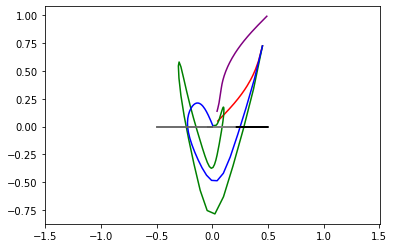

In [12]:
for points, (_, color) in zip(all_ways, optimizers):
  plt.plot(points[:, 0], points[:, 1], c=color)

plt.axis('equal')
#[(SGD, "red"), (Momentum, "green"), (NAG, "blue"), (Adadelta, "black"), (Adagrad, "gray"), (Adam, "purple")]

###  Часть 2: Обучение нейронной сети

In [13]:
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [14]:
def train(network, epochs, optim):
    loss = nn.NLLLoss()
    optimizer = optim(network.parameters())
    #optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    try:
        for epoch in range(epochs):
            losses = []
            accuracies = []
            for X, y in train_loader:
                network.zero_grad()
                prediction = network(X)
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.item())
                loss_batch.backward()
                optimizer.step()
                accuracies.append((np.argmax(prediction.data.numpy(), 1)==y.data.numpy()).mean())
            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(np.mean(accuracies))
            losses = []
            accuracies = []    
            for X, y in test_loader:
                prediction = network(X)
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.item())
                accuracies.append((np.argmax(prediction.data.numpy(), 1)==y.data.numpy()).mean())
            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(np.mean(accuracies))
            clear_output(True)
            print('\rEpoch {0}... (Train/Test) NLL: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
                        epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                        train_accuracy_epochs[-1], test_accuracy_epochs[-1]))
            plt.figure(figsize=(12, 5))
            plt.subplot(1, 2, 1)
            plt.plot(train_loss_epochs, label='Train')
            plt.plot(test_loss_epochs, label='Test')
            plt.xlabel('Epochs', fontsize=16)
            plt.ylabel('Loss', fontsize=16)
            plt.legend(loc=0, fontsize=16)
            plt.grid()
            plt.subplot(1, 2, 2)
            plt.plot(train_accuracy_epochs, label='Train accuracy')
            plt.plot(test_accuracy_epochs, label='Test accuracy')
            plt.xlabel('Epochs', fontsize=16)
            plt.ylabel('Loss', fontsize=16)
            plt.legend(loc=0, fontsize=16)
            plt.grid()
            plt.show()
    except KeyboardInterrupt:
        pass

In [15]:
max_epochs = 10

<i> 2.1 Сравните графики обучения для полносвязной нейросети на методах Adam, Adagrad, AdaDelta и SGD (на MNIST). </i>

In [16]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_layers = nn.Sequential(nn.Linear(784, 100),
                                           nn.ReLU(),
                                           nn.Linear(100,100),
                                           nn.ReLU(),
                                           nn.Linear(100, 10),
                                           nn.LogSoftmax(dim=1)
                                           )
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

Epoch 9... (Train/Test) NLL: 0.086/0.144	Accuracy: 0.974/0.967


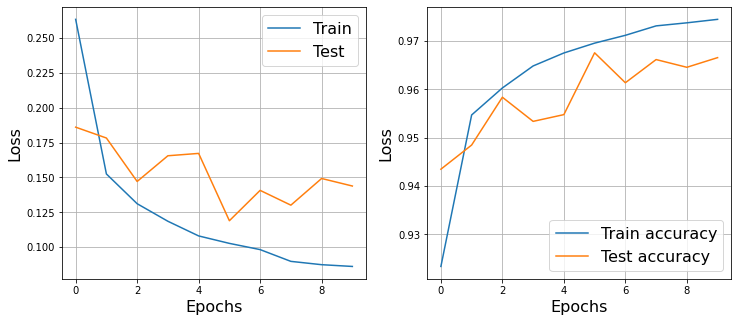

In [21]:
#Adam
network = NeuralNetwork()
train(network, max_epochs, Adam)

Epoch 9... (Train/Test) NLL: 50.153/50.894	Accuracy: 0.207/0.201


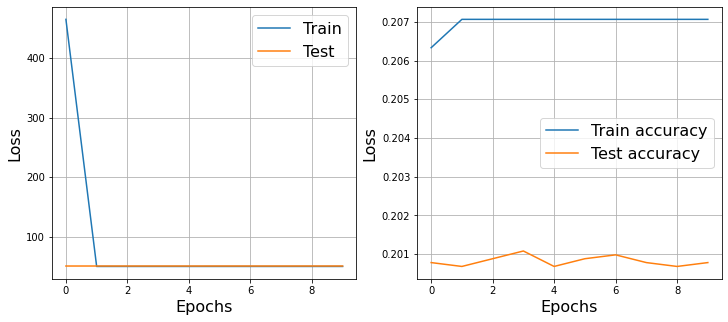

In [22]:
#Adadelta
network = NeuralNetwork()
train(network, max_epochs, Adadelta)
#не учится, self.lr уже на первой эпохе затухают до 5*10^(-45)

Epoch 49... (Train/Test) NLL: 1.344/1.367	Accuracy: 0.481/0.481


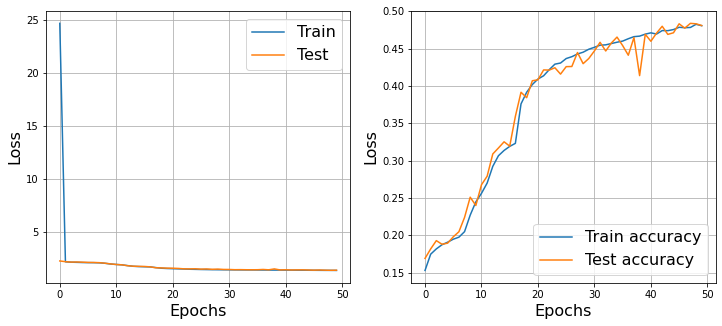

In [23]:
#Adagrad
network = NeuralNetwork()
train(network, 50, Adagrad)

Epoch 9... (Train/Test) NLL: 0.015/0.090	Accuracy: 0.995/0.978


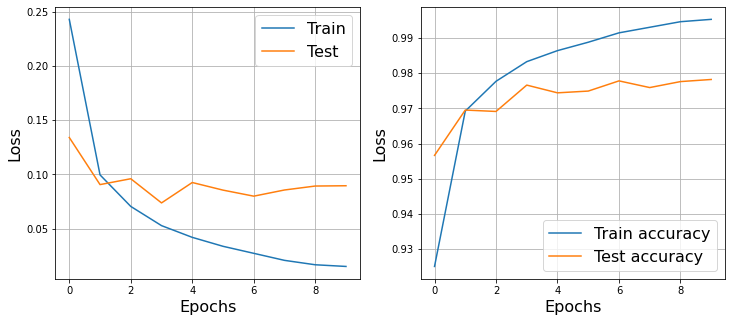

In [24]:
#SGD
network = NeuralNetwork()
train(network, max_epochs, SGD)

<i> 2.2 Сравните графики обучения для сверточной нейросети на методах Adam, Adagrad, AdaDelta и SGD. </i>

In [30]:
class ConvClassifier3(nn.Module):
    def __init__(self, image_size):
        super().__init__()
        self.conv_layers = nn.Sequential(nn.Conv2d(1, 8, 3, padding=1), 
                                         nn.ReLU(),
                                         nn.Conv2d(8, 16, 3, padding=1), 
                                         nn.ReLU(),
                                         nn.MaxPool2d(2),
                                         nn.Conv2d(16, 32, 3, padding=1))
        self.linear_layers = nn.Sequential(nn.Linear(image_size//2*image_size//2*32, 10), nn.LogSoftmax(dim=1))
        
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

Epoch 9... (Train/Test) NLL: 0.088/0.084	Accuracy: 0.972/0.976


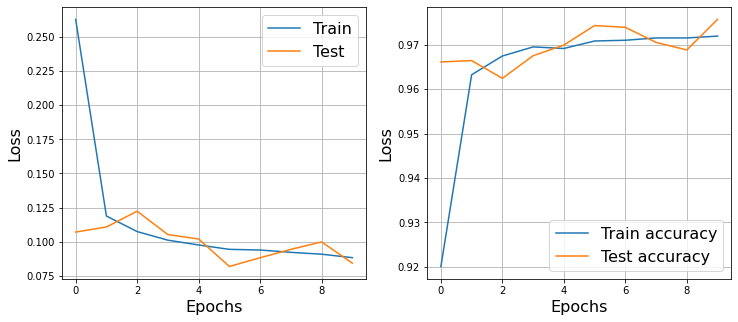

In [31]:
#Adam
network = ConvClassifier3(image_size=28)
train(network, max_epochs, Adam)

Epoch 14... (Train/Test) NLL: 39458.016/38899.361	Accuracy: 0.126/0.124


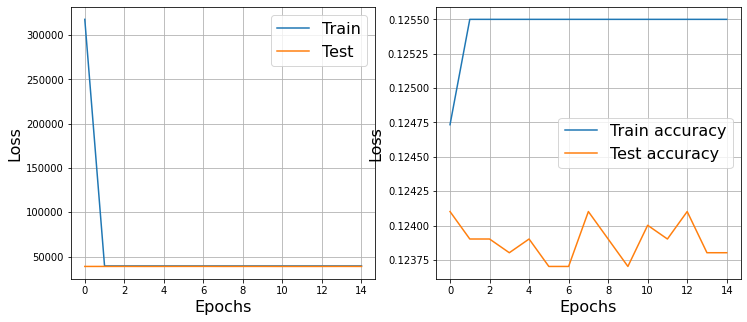

In [32]:
#Adadelta
network = ConvClassifier3(image_size=28)
train(network, 15, Adadelta)
#не учится, как и для полносвязной сети, получилось, self.lr слишком быстро затухает

Epoch 49... (Train/Test) NLL: 4.824/2.571	Accuracy: 0.101/0.113


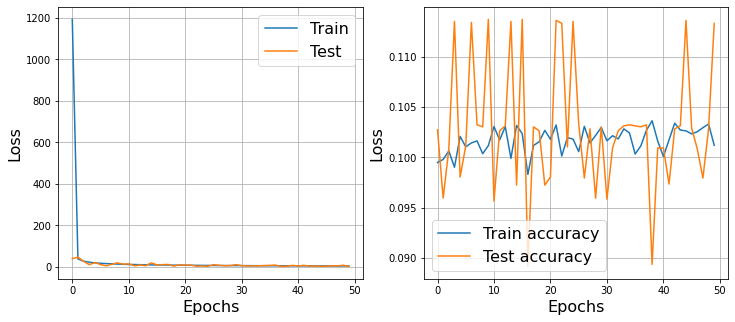

In [33]:
#Adagrad
network = ConvClassifier3(image_size=28)
train(network, 50, Adagrad)

Epoch 9... (Train/Test) NLL: 0.020/0.054	Accuracy: 0.993/0.986


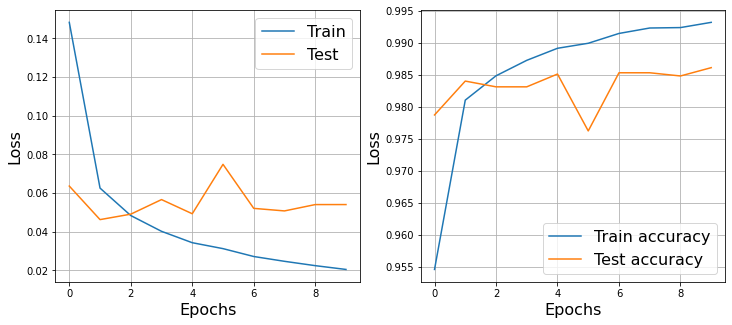

In [34]:
#SGD
network = ConvClassifier3(image_size=28)
train(network, max_epochs, SGD)